## Consider a building the bicubic interpolation operator faster?
The current bicubic interpolation operator works well but is not vectorized and only runs on the CPU

Note: I've updated the code so the interpolation operator might be slightly different from the original implementation since there seem to be several subtle errors.

In [1]:
import numpy as np
import scipy
import scipy.sparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple

from jaxhps.quadrature import (
    barycentric_lagrange_interpolation_matrix_2D,
    chebyshev_points,
)

from rlc_repo_link.src.data.data_transformations import (
    prep_conv_interp_2d,
    apply_interp_2d,
    # Maybe I could leverage the separability to use the 1d operators?
    prep_conv_interp_1d,
    apply_interp_1d,
)

In [2]:
# q_fn_handle = lambda x: q_gaussian_bumps(0.75 * x)
bump_center = jnp.array([0, 0.0])
# bump_center = jnp.array([0.0, 0.0])
amplitude = 2
sigma = 0.35
q_fn_handle = lambda x: amplitude * jnp.exp(-0.5*jnp.sum( ((x-bump_center)/sigma)**2 ,axis=-1))

In [3]:
tree_n_per_leaf = 16
tree_L = 3
tree_p = 16
tree_n = 2**tree_L * tree_n_per_leaf

print(f"L={tree_L}, N={tree_n}")

L=3, N=128


In [4]:
leaf_cheb_x = chebyshev_points(tree_p)
leaf_cheb_y = chebyshev_points(tree_p)[::-1]
leaf_to_tree = lambda xs: jnp.concatenate([
    (xs+1) * (1/2**tree_L) - 1 + (2*i/2**tree_L)
    for i in range(2**tree_L)
])
tree_cheb_x = leaf_to_tree(leaf_cheb_x)
tree_cheb_y = leaf_to_tree(leaf_cheb_y)

cell_offset = 0.5 # 0.5 for centered
leaf_unif_x = (2*cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=False)
leaf_unif_y = (2*cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=False) # [::-1]
# tree_unif_x = (cell_offset/tree_n)+jnp.linspace(-1.5, 0.8, tree_n, endpoint=False)
# tree_unif_y = (cell_offset/tree_n)+jnp.linspace(-0.6, 0.9,   tree_n, endpoint=False)
tree_unif_x = (2*cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=False)
tree_unif_y = (2*cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=False)

product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
leaf_cheb_xy = product_grid(leaf_cheb_x, leaf_cheb_y)
leaf_unif_xy = product_grid(leaf_unif_x, leaf_unif_y)
tree_unif_xy = product_grid(tree_unif_x, tree_unif_y)
tree_cheb_xy = product_grid(tree_cheb_x, tree_cheb_y)

In [5]:
tree_unif_x.max()

Array(0.9921875, dtype=float64)

In [6]:
tree_unif_x.min()

Array(-0.9921875, dtype=float64)

In [7]:
%%time
tree_unif_to_cheb_x, tree_unif_to_cheb_y = prep_conv_interp_2d(
    tree_unif_x,
    tree_unif_y,
    tree_cheb_xy,
    # use a zero-valued boundary condition to mimic empty neighboring leaves
    bc_modes=("zero", "zero"),
)

CPU times: user 252 ms, sys: 15.3 ms, total: 268 ms
Wall time: 299 ms


In [8]:
ref_q_unif = q_fn_handle(tree_unif_xy).reshape(tree_n, tree_n)
ref_q_cheb = q_fn_handle(tree_cheb_xy).reshape(2**tree_L*tree_p, 2**tree_L * tree_p)

In [9]:
script_q_cheb_from_unif = apply_interp_2d(
    tree_unif_to_cheb_x, tree_unif_to_cheb_y, ref_q_unif
).reshape(2**tree_L*tree_p, 2**tree_L * tree_p)

In [10]:
np.linalg.norm(script_q_cheb_from_unif-ref_q_cheb) / np.linalg.norm(ref_q_cheb)

0.0029577559713075013

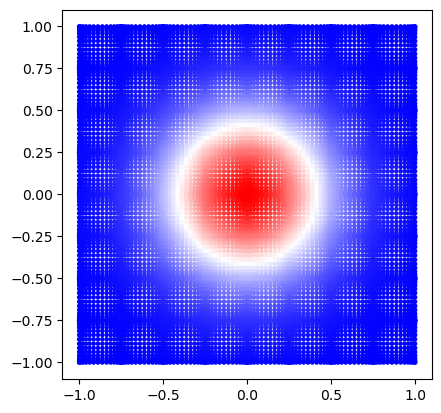

In [11]:
plt.scatter(*tree_cheb_xy.T, c=script_q_cheb_from_unif, s=5, cmap="bwr")
plt.gca().set_aspect(1)

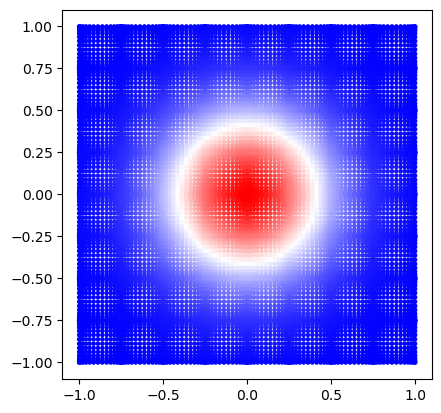

In [12]:
plt.scatter(*tree_cheb_xy.T, c=script_q_cheb_from_unif, s=5, cmap="bwr")
plt.gca().set_aspect(1)

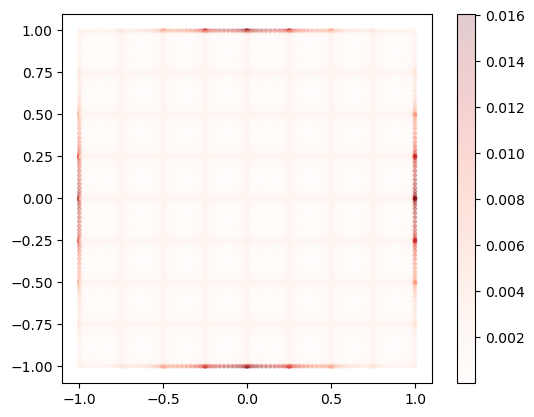

In [13]:
plt.scatter(*tree_cheb_xy.T, c=np.abs(script_q_cheb_from_unif-ref_q_cheb), s=5, alpha=0.2, cmap="Reds")
plt.colorbar()
plt.gca().set_aspect(1)

In [14]:
def prep_conv_interp_1d_faster(
    points: np.ndarray,
    xi: np.ndarray,
    bc_mode: str = None,
    a_neg_half: bool = True,
) -> scipy.sparse.csr_array:
    """Alternate implementation written to use some vectorization
    Prepares a sparse array to apply convolution for cubic interpolation
    Operates in a single dimension and can be applied to each dimension independently
    to work with higher-dimension data

    Assumes that the entries in `points` are sorted and evenly spaced
    Args:
        points (ndarray): original data grid points
        xi (ndarray): array of points to be sampled as a (m,)-shaped array
        bc_mode (string): how to handle the boundary conditions
            options:
                "periodic": wrap values around
                "extend": extrapolate the missing out-of-boundary values
                    using a rule for cartesian points: f(-1) = 3*f(0) - 3*f(1) + f(2)
                    (see R. Keys 1981 paper below)
                "zero": sets values outside the boundary to zero
        a_neg_half (bool): whether to use a=-1/2 for the convolution filter (otherwise use a=-3/4)
    Returns:
        conv_filter (m by n): sparse linear filter to perform
            cubic interpolation (on padded data)
            Apply to data values with `apply_interp_{1,2}d`
            Note: padding should not be needed except for the inside edge of a polar grid

    For the choice of convolution filter for cubic convolution
    See https://en.wikipedia.org/wiki/Bicubic_interpolation#Bicubic_convolution_algorithm
    and R. Keys (1981). "Cubic convolution interpolation for digital image processing".
        IEEE Transactions on Acoustics, Speech, and Signal Processing.
        29 (6): 1153–1160. Bibcode:1981ITASS..29.1153K. CiteSeerX 10.1.1.320.776.
        doi:10.1109/TASSP.1981.1163711 .
    """
    bc_mode = bc_mode.lower() if bc_mode is not None else "zero"
    # Helper variables
    periodic_mode = bc_mode == "periodic"
    extend_mode = bc_mode == "extend"
    zero_mode = bc_mode == "zero"

    if a_neg_half:
        # with a=-1/2, standard choice (seems to be the Catmull-Rom filter?)
        cubic_conv_matrix = 0.5 * np.array(
            [[0, 2, 0, 0], [-1, 0, 1, 0], [2, -5, 4, -1], [-1, 3, -3, 1]]
        )
    else:
        # with a=-3/4, computed with sympy
        # Sometimes gives lower error but has weaker theoretical properties...
        cubic_conv_matrix = 0.25 * np.array(
            [[0, 4, 0, 0], [-3, 0, 3, 0], [6, -9, 6, -3], [-3, 5, -5, 3]]
        )

    n = points.shape[0]
    min_pt = points[0]
    # interval between regularly sampled points
    itvl = (points[-1] - points[0]) / ( n - 1 )
    m = xi.shape[0]

    # Faster to build in LIL form then convert later to CSR
    interp_op = scipy.sparse.lil_array((m, n))

    js_float, xs_offset = np.divmod(xi - min_pt, itvl)
    js = js_float.astype(int)
    print(f"js shape: {js.shape}; xs_offset shape: {xs_offset.shape}")
    print(f"js_float[0]: {js_float[0]}; xs_offset[0]: {xs_offset[0]}")
    pos_rel_vec = xs_offset / itvl
    monomials_mat = np.stack(
        [
            np.ones(m),
            pos_rel_vec,
            pos_rel_vec**2,
            pos_rel_vec**3
        ], axis=1
    )
    filters_local = monomials_mat @ cubic_conv_matrix

    # First handle the cases fully in bounds...
    # Identify the target points that are fully in bounds...
    tgt_idcs = np.arange(m)
    tgt_pts_in_bounds  = np.logical_and(js>=1, js<=n-3) # boolean array
    tgt_idcs_in_bounds = tgt_idcs[tgt_pts_in_bounds]    # index array (target points in bounds)
    js_idcs_in_bounds  = js[tgt_pts_in_bounds]          # index array (~relevant source points)

    # Just load the values one-by-one to avoid unholy indexing sorcery
    filters_local_in_bounds = filters_local[tgt_pts_in_bounds]
    interp_op[tgt_idcs_in_bounds, js_idcs_in_bounds-1] = filters_local_in_bounds[:, 0]
    interp_op[tgt_idcs_in_bounds, js_idcs_in_bounds+0] = filters_local_in_bounds[:, 1]
    interp_op[tgt_idcs_in_bounds, js_idcs_in_bounds+1] = filters_local_in_bounds[:, 2]
    interp_op[tgt_idcs_in_bounds, js_idcs_in_bounds+2] = filters_local_in_bounds[:, 3]

    # Handle the boundary conditions 
    tgt_pts_out_bounds  = np.logical_not(tgt_pts_in_bounds)
    tgt_idcs_out_bounds = tgt_idcs[tgt_pts_out_bounds]
    js_idcs_out_bounds  = js[tgt_pts_out_bounds]
    if periodic_mode:
        filters_local_out_bounds = filters_local[tgt_pts_out_bounds]
        interp_op[tgt_idcs_out_bounds, (js_idcs_out_bounds-1)%n] = filters_local_out_bounds[:, 0]
        interp_op[tgt_idcs_out_bounds, (js_idcs_out_bounds+0)%n] = filters_local_out_bounds[:, 1]
        interp_op[tgt_idcs_out_bounds, (js_idcs_out_bounds+1)%n] = filters_local_out_bounds[:, 2]
        interp_op[tgt_idcs_out_bounds, (js_idcs_out_bounds+2)%n] = filters_local_out_bounds[:, 3]
    elif zero_mode:
        # # This version matches the original code...
        # for jl in range(-2, 1):
        #     print(f"jl={jl}") # jl = -2, -1, 0
        #     tgt_pts_jl  = (js==jl)
        #     tgt_idcs_jl = tgt_idcs[tgt_pts_jl]
        #     js_idcs_jl  = js[tgt_pts_jl]
        #     print(f"interp_op[tgt_idcs_jl, :{jl+3}] = filters_local[tgt_pts_jl, :{jl+3}]")
        #     interp_op[tgt_idcs_jl, :jl+3] = filters_local[tgt_pts_jl, :jl+3]
        #     # print(f"interp_op[tgt_idcs_jl, :{jl+3}] = filters_local[tgt_pts_jl, -{jl+3}:]")
        #     # interp_op[tgt_idcs_jl, :jl+3] = filters_local[tgt_pts_jl, -(jl+3):]
        # for jr in range(n-2, n):
        # # for jr in range(n-2, n): # it seems like a mistake to exclude n?
        #     print(f"jr={jr}") # jr = n-2, n-1, n (?)
        #     tgt_pts_jr  = (js==jr)
        #     tgt_idcs_jr = tgt_idcs[tgt_pts_jr]
        #     js_idcs_jr  = js[tgt_pts_jr]
        #     print(f"interp_op[tgt_idcs_jl, {jr-1}:] = filters_local[tgt_pts_jr, :{n-jr+1}]")
        #     interp_op[tgt_idcs_jr, jr-1:] = filters_local[tgt_pts_jr, :n-jr+1]
        # This is slightly more accurate since it fixes a subtle error (previously the filter got flipped)
        for jl in range(-2, 1):
            print(f"jl={jl}") # jl = -2, -1, 0
            tgt_pts_jl  = (js==jl)
            tgt_idcs_jl = tgt_idcs[tgt_pts_jl]
            js_idcs_jl  = js[tgt_pts_jl]
            # print(f"interp_op[tgt_idcs_jl, :{jl+3}] = filters_local[tgt_pts_jl, :{jl+3}]")
            # interp_op[tgt_idcs_jl, :jl+3] = filters_local[tgt_pts_jl, :jl+3]
            print(f"interp_op[tgt_idcs_jl, :{jl+3}] = filters_local[tgt_pts_jl, -{jl+3}:]")
            interp_op[tgt_idcs_jl, :jl+3] = filters_local[tgt_pts_jl, -(jl+3):]
        for jr in range(n-2, n+1):
        # for jr in range(n-2, n): # it seems like a mistake to exclude n?
            print(f"jr={jr}") # jr = n-2, n-1, n (?)
            tgt_pts_jr  = (js==jr)
            tgt_idcs_jr = tgt_idcs[tgt_pts_jr]
            js_idcs_jr  = js[tgt_pts_jr]
            print(f"interp_op[tgt_idcs_jl, {jr-1}:] = filters_local[tgt_pts_jr, :{n-jr+1}]")
            interp_op[tgt_idcs_jr, jr-1:] = filters_local[tgt_pts_jr, :n-jr+1]
    else:
        extend_filter_left  = jnp.array([3, -3, 1])
        extend_filter_right = jnp.array([1, -3, 3])
        for i in tgt_idcs_out_bounds:
            j = js[i]
            filter_local = filters_local[i]
            # Assumes zero value beyond the extra single-cell padding
            # Extrapolation rule was linear anyway so fold down the extrapolation
            # into a reduced-length filter
            if extend_mode:
                if j < 1 and (j + 3) >= 0:
                    filter_folded = filter_local[1:] \
                        + filter_local[0] * extend_filter_left
                    # interp_op[i, : j + 3] = filter_folded[: j + 3] # Original version
                    interp_op[i, : j + 3] = filter_folded[-(j + 3): ] # Flipped vs. the main code; slightly better
                # elif j < n and (j + 3) >= n:
                elif j <= n and (j + 3) >= n:
                    filter_folded = filter_local[:-1] \
                        + filter_local[-1] * extend_filter_right
                    interp_op[i, j - 1 :] = filter_folded[: n - j + 1]
            else:  # bc_mode == "zero" case
                if j < 1 and (j + 3) >= 0:
                    interp_op[i, : j + 3] = filter_local[: j + 3] # Shouldn't this go the other way??
                elif j < n and (j + 3) >= n:
                    interp_op[i, j - 1 :] = filter_local[: n - j + 1]

    # Convert for slightly faster application
    interp_op = scipy.sparse.csr_array(interp_op)
    return interp_op
        
def prep_conv_interp_2d_faster(
    points_x: np.ndarray,
    points_y: np.ndarray,
    xi: np.ndarray,
    bc_modes: None | str | Tuple = None,
    a_neg_half: bool = True,
) -> Tuple[scipy.sparse.csr_array, scipy.sparse.csr_array]:
    should_split = hasattr(bc_modes, "__len__") and len(bc_modes) == 2
    bc_mode_x = bc_modes[0] if should_split else bc_modes
    bc_mode_y = bc_modes[1] if should_split else bc_modes
    interp_op_x = prep_conv_interp_1d_faster(
        points_x, xi[:, 0], bc_mode=bc_mode_x, a_neg_half=a_neg_half
    )
    interp_op_y = prep_conv_interp_1d_faster(
        points_y, xi[:, 1], bc_mode=bc_mode_y, a_neg_half=a_neg_half
    )
    return interp_op_x, interp_op_y

In [15]:
%%time
tree_unif_to_cheb_x_faster, tree_unif_to_cheb_y_faster = prep_conv_interp_2d_faster(
    tree_unif_x,
    tree_unif_y,
    tree_cheb_xy,
    # use a zero-valued boundary condition to mimic empty neighboring leaves
    bc_modes=("zero", "zero"),
)

js shape: (16384,); xs_offset shape: (16384,)
js_float[0]: -1.0; xs_offset[0]: 0.0078125
jl=-2
interp_op[tgt_idcs_jl, :1] = filters_local[tgt_pts_jl, -1:]
jl=-1
interp_op[tgt_idcs_jl, :2] = filters_local[tgt_pts_jl, -2:]
jl=0
interp_op[tgt_idcs_jl, :3] = filters_local[tgt_pts_jl, -3:]
jr=126
interp_op[tgt_idcs_jl, 125:] = filters_local[tgt_pts_jr, :3]
jr=127
interp_op[tgt_idcs_jl, 126:] = filters_local[tgt_pts_jr, :2]
jr=128
interp_op[tgt_idcs_jl, 127:] = filters_local[tgt_pts_jr, :1]
js shape: (16384,); xs_offset shape: (16384,)
js_float[0]: 15.0; xs_offset[0]: 0.0078125
jl=-2
interp_op[tgt_idcs_jl, :1] = filters_local[tgt_pts_jl, -1:]
jl=-1
interp_op[tgt_idcs_jl, :2] = filters_local[tgt_pts_jl, -2:]
jl=0
interp_op[tgt_idcs_jl, :3] = filters_local[tgt_pts_jl, -3:]
jr=126
interp_op[tgt_idcs_jl, 125:] = filters_local[tgt_pts_jr, :3]
jr=127
interp_op[tgt_idcs_jl, 126:] = filters_local[tgt_pts_jr, :2]
jr=128
interp_op[tgt_idcs_jl, 127:] = filters_local[tgt_pts_jr, :1]
CPU times: user 475 

In [16]:
notebook_q_cheb_from_unif = apply_interp_2d(
    tree_unif_to_cheb_x_faster, tree_unif_to_cheb_y_faster, ref_q_unif
).reshape(2**tree_L*tree_p, 2**tree_L * tree_p)

In [17]:
np.linalg.norm(notebook_q_cheb_from_unif-ref_q_cheb) / np.linalg.norm(ref_q_cheb)

0.0029577559713075013

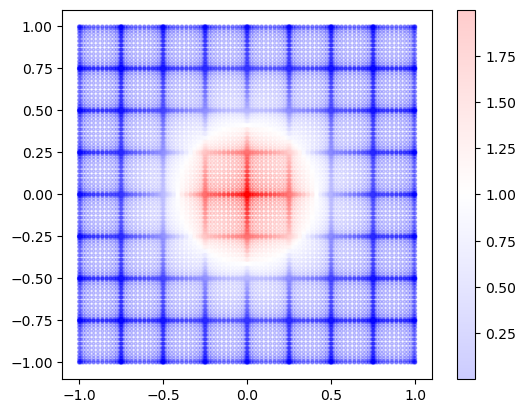

In [18]:
plt.scatter(*tree_cheb_xy.T, c=notebook_q_cheb_from_unif, s=5, alpha=0.2, cmap="bwr")
plt.colorbar()
plt.gca().set_aspect(1)

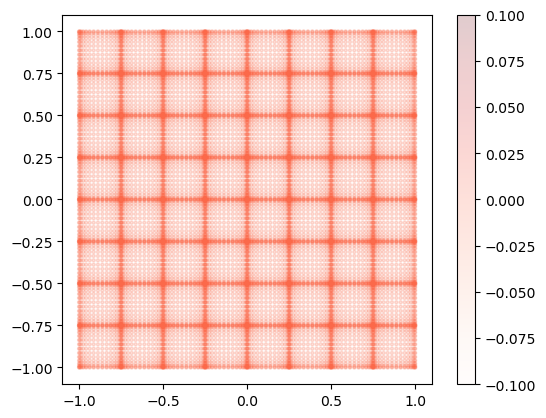

In [19]:
plt.scatter(*tree_cheb_xy.T, c=np.abs(notebook_q_cheb_from_unif-script_q_cheb_from_unif), s=5, alpha=0.2, cmap="Reds")
plt.colorbar()
plt.gca().set_aspect(1)

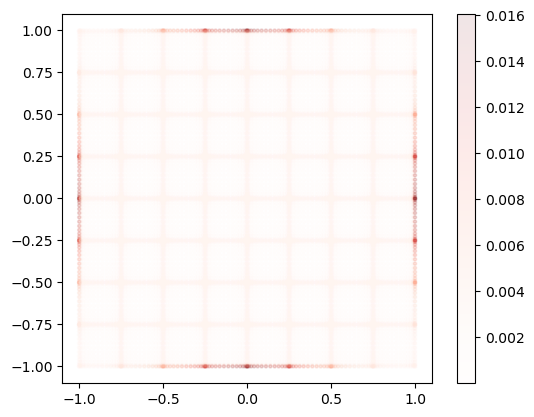

In [20]:
plt.scatter(*tree_cheb_xy.T, c=np.abs(notebook_q_cheb_from_unif-ref_q_cheb), s=5, alpha=0.1, cmap="Reds")
plt.colorbar()
plt.gca().set_aspect(1)

In [21]:
matches_in_x = np.allclose(tree_unif_to_cheb_x_faster.todense(), tree_unif_to_cheb_x.todense())
matches_in_y = np.allclose(tree_unif_to_cheb_y_faster.todense(), tree_unif_to_cheb_y.todense())
print(f"Matches? {matches_in_x and matches_in_y}")
print(f"Matches in x: {matches_in_x}")
print(f"Matches in y: {matches_in_y}")

Matches? True
Matches in x: True
Matches in y: True
